In [1]:
import keras.utils
import tensorflow as tf
from tensorflow.keras import models, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout, Input, Concatenate, GlobalAvgPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import tensorflow.keras.backend as K
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import os
import json

In [2]:
VARIABLES = ['ActivityCounts', 'Barometer', 'BloodPerfusion',
             'BloodPulseWave', 'EnergyExpenditure', 'HR',
             'HRV', 'RESP', 'Steps', 'SkinTemperature']

In [3]:
GRAYSCALE = False # grayscale or rgb

# Import data

In [4]:
variable = {'phF': 0, 'MF': 1}['phF'] # TODO: for now just classify one variable

In [5]:
path = './Output'

In [6]:
# dimensions
N, HEIGHT, WIDTH, CHANNELS = sum([1 for p in os.listdir(path) if (p[:14] == 'feature_vector' and p[:19] != 'feature_vector_stat')]), \
                             *np.load(path + '/feature_vector0.npy').shape
CHANNELS = len(VARIABLES) if GRAYSCALE else CHANNELS # reduce channels for grayscale

# metadata (subjectID etc.)
with open(path + '/metadata.txt') as f:
    metadata = f.read()
metadata = json.loads(metadata.replace('\'', '\"').replace('False', 'false').replace('True', 'true')) # doesn't accept other chars

In [7]:
print(f'Total datapoints: {N}')

Total datapoints: 3097


# Train/validation split

In [8]:
VALIDATION_SIZE = 0.2

In [9]:
# use unaugmented data for validation set
non_augmented = [i for i, meta in enumerate(metadata) if meta['augmented'] == False]

validation_indices = np.random.choice(non_augmented, int(N * VALIDATION_SIZE), replace=False)
training_indices = np.delete(np.arange(N), validation_indices)

In [10]:
print(f'Training set: {len(training_indices)}')
print(f'Validation set: {len(validation_indices)}')

Training set: 2478
Validation set: 619


# Define data generator

In [11]:
# image-wise
def rgb2gray(rgb):
    """greyscale = 0.2989 * red + 0.5870 * green + 0.1140 * blue"""
    return np.dot(rgb[:, :, :3], [0.2989, 0.5870, 0.1140])

In [12]:
class DataGenerator(Sequence):

    def __init__(self, data_path: str, indices_dataset: list, batch_size=32, dim=(HEIGHT, WIDTH), n_channels=CHANNELS, shuffle=True):
        self.data_path = data_path # path to full dataset
        self.dim = dim # image dimension
        self.batch_size = batch_size
        self.indices_dataset = indices_dataset # indices of full dataset (different for train/validation/test set)
        self.n_channels = n_channels
        self.shuffle = shuffle

        self.on_epoch_end() # shuffle data for each epoch

    def on_epoch_end(self):
        """
        Shuffle data for each epoch
        """
        if self.shuffle:
            np.random.shuffle(self.indices_dataset)

    def __data_generation(self, indices):
        """
        Loads and returns datapoints[indices]
        """
        # init
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty(self.batch_size, dtype=float) # TODO: int for non-logits

        # load individual datapoints
        for i, index in enumerate(indices):
            images = np.load(self.data_path + f'/feature_vector{index}.npy', allow_pickle=True)
            if GRAYSCALE:
                images_gray = np.empty((HEIGHT, WIDTH, self.n_channels))
                for j in range(len(VARIABLES)):
                    image_rgb = images[:, :, (3 * j): (3 * (j + 1))]
                    image_gray = rgb2gray(image_rgb)
                    images_gray[:, :, j] = image_gray
                images = images_gray

            X[i, ] = images
            y[i] = np.load(self.data_path + f'/labels{index}.npy', allow_pickle=True)[variable] # TODO: for now just one variable

        return X, y

    def __len__(self):
        """
        Number of batches per epoch
        """
        return int(np.floor(len(self.indices_dataset) / self.batch_size))

    def __getitem__(self, index):
        """
        Generates batch[index]
        """
        # calculate indices of batch
        indices = self.indices_dataset[index * self.batch_size:(index + 1) * self.batch_size]

        # generate batch
        X, y = self.__data_generation(indices)

        return X, y

# Upsampling

In [13]:
UPSAMPLING_STRATEGY = 'nothing' # ['repeat', 'nothing']

In [14]:
def check_imbalance(path_to_labels, indices):
    """Returns indices of positives/negatives"""
    y = np.empty((len(indices), 2), dtype=int)
    for i, index in enumerate(indices):
        y[i, ] = np.load(path_to_labels + f'/labels{index}.npy', allow_pickle=True)

    positives = np.where(y[:, variable] == 1)[0] # TODO: for now just one variable
    negatives = np.where(y[:, variable] == 0)[0] # TODO: for now just one variable

    return np.array(indices)[positives], np.array(indices)[negatives]


# validation set
positives, negatives = check_imbalance(path, validation_indices)
print(f'validation: (+: {len(positives)}, -: {len(negatives)})')

# training set
positives, negatives = check_imbalance(path, training_indices)
print(f'train_set: (+: {len(positives)}, -: {len(negatives)})')

sample_weight = len(negatives) / len(positives) # for weighted cross-entropy

# upsampling training set
if UPSAMPLING_STRATEGY == 'repeat':
    upsampled_indices = np.random.choice(negatives, size=(len(positives) - len(negatives)), replace=True) # with replacement
    upsampled_indices = np.append(upsampled_indices, np.arange(N))
    training_indices = np.append(positives, negatives) # update

    positives, negatives = check_imbalance(path, upsampled_indices)
    print(f'train_set (upsampled): (+: {len(positives)}, -: {len(negatives)})')
if UPSAMPLING_STRATEGY == 'nothing':
    pass

print(f'\nWeighted loss function: weight = {sample_weight}')

validation: (+: 456, -: 163)
train_set: (+: 1836, -: 642)

Weighted loss function: weight = 0.34967320261437906


# CNN

Data generators

In [15]:
training_batch_generator = DataGenerator(data_path=path, indices_dataset=training_indices, batch_size=32)
validation_batch_generator = DataGenerator(data_path=path, indices_dataset=validation_indices, batch_size=32)

Model

In [16]:
# wrapper functions
def weighted_cross_entropy(weight):
    def weighted_cross_entropy_with_logits(labels, logits):
        loss = tf.nn.weighted_cross_entropy_with_logits(
            labels, logits, weight
        )
        return loss
    return weighted_cross_entropy_with_logits


class accuracy_with_logits(tf.keras.metrics.Accuracy):

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(tf.math.sigmoid(y_pred))
        return super(accuracy_with_logits, self).update_state(y_true, y_pred, sample_weight)

class recall_with_logits(tf.keras.metrics.Recall):

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(tf.math.sigmoid(y_pred))
        return super(recall_with_logits, self).update_state(y_true, y_pred, sample_weight)

class precision_with_logits(tf.keras.metrics.Precision):

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(tf.math.sigmoid(y_pred))
        return super(precision_with_logits, self).update_state(y_true, y_pred, sample_weight)

class F1(tf.keras.metrics.Metric):

    def __init__(self, name='f1', **kwargs):
        super(F1, self).__init__(name=name, **kwargs)
        self.tp = self.add_weight(name="ctp", initializer="zeros")
        self.tn = self.add_weight(name="ctp", initializer="zeros")
        self.fp = self.add_weight(name="ctp", initializer="zeros")
        self.fn = self.add_weight(name="ctp", initializer="zeros")

        self.positives = self.add_weight(name="ctp", initializer="zeros")
        self.positives_pred = self.add_weight(name="ctp", initializer="zeros")
        self.negatives = self.add_weight(name="ctp", initializer="zeros")
        self.negatives_pred = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(tf.math.sigmoid(y_pred))

        self.positives = K.sum(y_true)
        self.positives_pred = K.sum(y_pred)
        self.negatives = K.sum((1 - y_true))
        self.negatives_pred = K.sum((1 - y_pred))

        self.tp = K.sum(y_true * y_pred)
        self.tn = K.sum((1 - y_true) * (1 - y_pred))
        self.fp = K.sum((1 - y_true) * y_pred)
        self.fn = K.sum(y_true * (1 - y_pred))

    def result(self):
        precision = self.tp / (self.positives_pred + K.epsilon())
        recall = self.tp / (self.positives + K.epsilon())
        f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

        precision_negatives = self.tn / (self.negatives_pred + K.epsilon())
        recall_negatives = self.tn / (self.negatives + K.epsilon())
        f1_negatives = 2 * (precision_negatives * recall_negatives) / (precision_negatives + recall_negatives + K.epsilon())

        return (self.positives * f1 + self.negatives * f1_negatives) / (self.positives + self.negatives + K.epsilon())

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.positives = 0.0
        self.positives_pred = 0.0
        self.negatives = 0.0
        self.negatives_pred = 0.0

        self.tp = 0.0
        self.tn = 0.0
        self.fp = 0.0
        self.fn = 0.0

In [17]:
# TODO: make possible for grayscale
class CNN(tf.keras.Model):

    def __init__(self, name='custom_CNN', **kwargs):
        super(CNN, self).__init__(name, **kwargs)

        self.in_shape = (HEIGHT, WIDTH, CHANNELS)
        self.in_shape_mobilenet = (HEIGHT, WIDTH, 3)

        # MobileNetV2 embedding
        self.mobilenet = MobileNetV2(input_shape=self.in_shape_mobilenet, weights='imagenet', include_top=False)
        self.mobilenet.trainable = False # TODO: make customizable (finetuning)
        self.out_shape_mobilenet = self.mobilenet.layers[-1].output_shape # for one spectrogram

        # Concatenation
        self.concat = Concatenate(name='concat')

        # Global pooling
        self.pool = GlobalAvgPool2D(name='global_avg_pool')

        # TODO: more sophisticated dense (dropout, regularizer, init., ...)
        # Fully-connected network
        self.flatten = Flatten(name='flatten', input_shape=(self.out_shape_mobilenet * (CHANNELS // 3), ))
        self.dense1 = Dense(64, activation='relu', name='dense1')
        self.dense2 = Dense(1, name='dense2') # keep logits
        self.out_shape = 1

        # build graph
        self.build_graph()

    def build_graph(self):
        self.build(input_shape=(None, *self.in_shape))
        x = Input(shape=self.in_shape)
        Model(inputs=[x], outputs=self.call(x))

    def call(self, inputs):
        """
        Model predictions (logits)
        :param inputs: all spectrograms of shape (HEIGHT, WIDTH, CHANNELS)
        :return: class prediction (logits)
        """
        # MobileNetV2 embeddings
        x = [self.mobilenet(inputs[..., i:i+3], training=False) for i in range(0, CHANNELS, 3)]

        # Concatenation
        x = self.concat(x)

        # Global pooling
        x = self.pool(x)

        # Fully-connected network
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)

        return x

Training

In [18]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

from datetime import datetime
from packaging import version

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, "This notebook requires TensorFlow 2.0 or above."

import tensorboard
tensorboard.__version__

logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

TensorFlow version:  2.6.0


In [22]:
model = CNN()

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss=weighted_cross_entropy(sample_weight),
              metrics=['accuracy'])

history = model.fit_generator(generator=training_batch_generator,
                              validation_data=validation_batch_generator,
                              epochs=10,
                              callbacks=[tensorboard_callback])

Epoch 1/10
77/77 [==============================] - 108s 1s/step - loss: 0.4992 - accuracy: 0.4387 - val_loss: 0.3450 - val_accuracy: 0.4079
Epoch 2/10
77/77 [==============================] - 47s 611ms/step - loss: 0.3274 - accuracy: 0.5300 - val_loss: 0.3385 - val_accuracy: 0.5411
Epoch 3/10
77/77 [==============================] - 47s 605ms/step - loss: 0.3068 - accuracy: 0.5925 - val_loss: 0.3264 - val_accuracy: 0.4441
Epoch 4/10
77/77 [==============================] - 47s 610ms/step - loss: 0.2971 - accuracy: 0.6213 - val_loss: 0.3212 - val_accuracy: 0.4786
Epoch 5/10
77/77 [==============================] - 47s 611ms/step - loss: 0.2685 - accuracy: 0.6575 - val_loss: 0.5462 - val_accuracy: 0.2796
Epoch 6/10
77/77 [==============================] - 46s 591ms/step - loss: 0.2756 - accuracy: 0.6554 - val_loss: 0.3794 - val_accuracy: 0.7155
Epoch 7/10
77/77 [==============================] - 46s 595ms/step - loss: 0.2352 - accuracy: 0.7139 - val_loss: 0.3159 - val_accuracy: 0.4901
E

In [23]:
%tensorboard --logdir logs

Launching TensorBoard...

In [37]:
# The function to be traced.
@tf.function
def my_func(x):
    # A simple hand-rolled layer.
    model = CNN()
    return model(training_batch_generator.__getitem__(0))

# Set up logging.
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = 'logs/func/%s' % stamp
writer = tf.summary.create_file_writer(logdir)


# Bracket the function call with
# tf.summary.trace_on() and tf.summary.trace_export().
tf.summary.trace_on(graph=True, profiler=True)
# Call only one tf.function when tracing.
z = my_func(np.load(path + f'/feature_vector{0}.npy', allow_pickle=True))
with writer.as_default():
    tf.summary.trace_export(
        name="my_func_trace",
        step=0,
        profiler_outdir=logdir)

TypeError: in user code:

    C:\Users\jjung\AppData\Local\Temp\ipykernel_27716\2948352088.py:6 my_func  *
        return model(training_batch_generator.__getitem__(0))
    C:\Users\jjung\AppData\Local\Temp\ipykernel_27716\2500241713.py:43 call  *
        x = [self.mobilenet(inputs[..., i:(i + 3)], training=False) for i in range(0, CHANNELS, 3)]

    TypeError: tuple indices must be integers or slices, not tuple


In [30]:
%tensorboard --logdir logs/func

Launching TensorBoard...

In [36]:
model = CNN()

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss=weighted_cross_entropy(sample_weight),
              metrics=['accuracy'])

model.summary()

Model: "cnn_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 12, 4, 1280)       2257984   
_________________________________________________________________
concat (Concatenate)         (None, 12, 4, 12800)      0         
_________________________________________________________________
global_avg_pool (GlobalAvera (None, 12800)             0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dense1 (Dense)               (None, 64)                819264    
_________________________________________________________________
dense2 (Dense)               (None, 1)                 65        
Total params: 3,077,313
Trainable params: 819,329
Non-trainable params: 2,257,984
_____________________________________________

In [26]:
%tensorboard --logdir logs/fit

Launching TensorBoard...

In [326]:
model = CNN()

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss=weighted_cross_entropy(sample_weight),
              metrics=[accuracy_with_logits(), recall_with_logits(), precision_with_logits(), F1()])

model.summary()

Model: "cnn_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 12, 4, 1280)       2257984   
_________________________________________________________________
concat (Concatenate)         (None, 12, 4, 12800)      0         
_________________________________________________________________
global_avg_pool (GlobalAvera (None, 12800)             0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dense1 (Dense)               (None, 64)                819264    
_________________________________________________________________
dense2 (Dense)               (None, 1)                 65        
Total params: 3,077,313
Trainable params: 819,329
Non-trainable params: 2,257,984
___________________________________________

In [ ]:
model = CNN()

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss=weighted_cross_entropy(sample_weight),
              metrics=['accuracy'])

history = model.fit_generator(generator=training_batch_generator,
                              validation_data=validation_batch_generator,
                              epochs=10)

In [ ]:
%%time
# save best performing model
checkpoint_path_f1 = './temp/checkpoint_model_f1'
model_checkpoint_callback_f1 = ModelCheckpoint(filepath=checkpoint_path_f1,
                                            save_weights_only=True,
                                            monitor='val_f1',
                                            save_best_only=True)

# train
history = model.fit_generator(generator=training_batch_generator,
                              validation_data=validation_batch_generator,
                              epochs=300,
                              callbacks=[model_checkpoint_callback_f1])

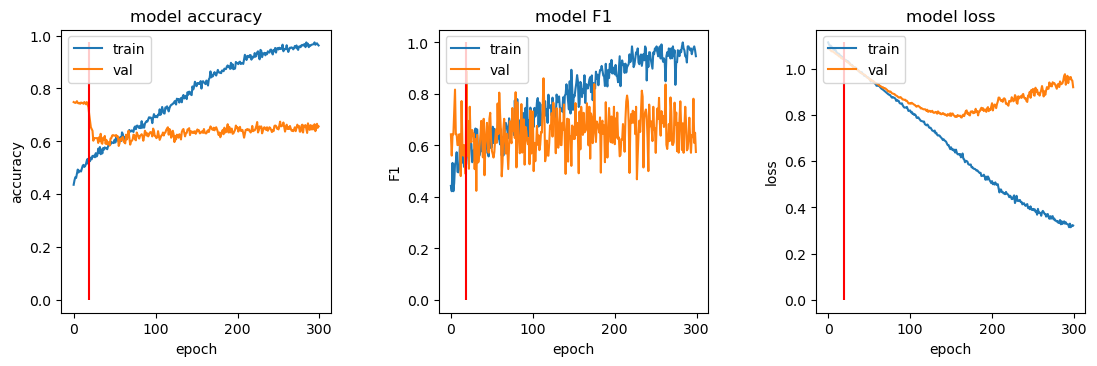

In [21]:
# plot training curve
plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.7,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

best_model_epoch = np.argmax(history.history['val_f1'])

# metric
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.vlines(x=best_model_epoch, ymin=0, ymax=max(history.history['accuracy'] + history.history['val_accuracy']), color='red')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 3, 2)
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.vlines(x=best_model_epoch, ymin=0, ymax=max(history.history['f1'] + history.history['val_f1']), color='red')
plt.title('model F1')
plt.ylabel('F1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# loss
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.vlines(x=best_model_epoch, ymin=0, ymax=max(history.history['loss'] + history.history['val_loss']), color='red')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

# Evaluation (latest)

In [25]:
# save latest model
current_model = tf.keras.models.clone_model(model)

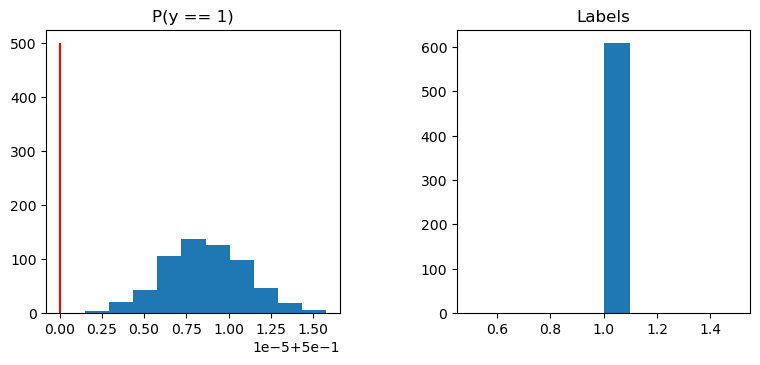

In [48]:
# predict on validation set
plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.2,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

y_pred = current_model.predict(validation_batch_generator)
y_pred = tf.math.sigmoid(y_pred).numpy() # TODO: for logits

# for probs
plt.subplot(1, 2, 1)
plt.hist(y_pred.reshape(-1))
plt.title('P(y == 1)')
plt.vlines(x=0.5, ymin=0, ymax=500, color='red')

y_pred = np.where(y_pred > 0.5, 1, 0) # as labels
plt.subplot(1, 2, 2)
plt.hist(y_pred.reshape(-1))
plt.title('Labels')

plt.show()

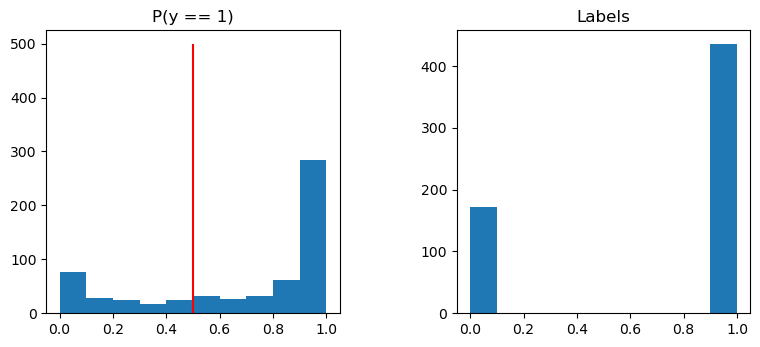

In [22]:
# predict on validation set
plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.2,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

y_pred = model.predict(validation_batch_generator)
y_pred = tf.math.sigmoid(y_pred).numpy() # TODO: for logits

# for probs
plt.subplot(1, 2, 1)
plt.hist(y_pred.reshape(-1))
plt.title('P(y == 1)')
plt.vlines(x=0.5, ymin=0, ymax=500, color='red')

y_pred = np.where(y_pred > 0.5, 1, 0) # as labels
plt.subplot(1, 2, 2)
plt.hist(y_pred.reshape(-1))
plt.title('Labels')

plt.show()

In [23]:
# load test data
print(f'Test set: {len(validation_indices)}') # TODO: separate test-set

test_batch_generator = DataGenerator(data_path=path, indices_dataset=validation_indices, batch_size=1) # TODO: separate test-set
y_test = np.empty(0)
for batch_index in range(len(test_batch_generator)):
    _, y_test_batch = test_batch_generator.__getitem__(batch_index)
    y_test = np.append(y_test, y_test_batch)

Test set: 619


accuracy: 0.6558966074313409
balanced accuracy: 0.5655416770066451
f1 (weighted): 0.6621012358228863
recall (weighted): 0.6558966074313409
precision (weighted): 0.6694062300361326


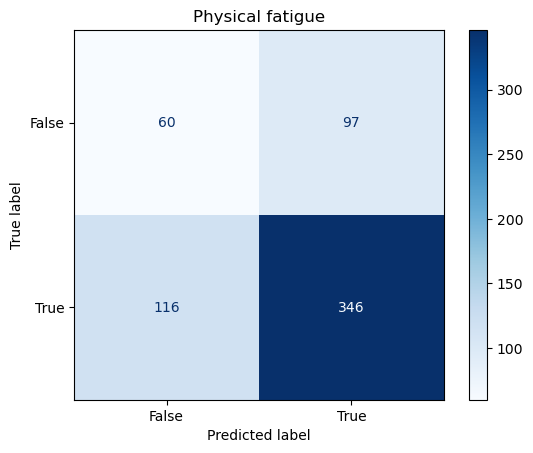

In [24]:
# classification metrics
# predict
y_test_pred = model.predict(test_batch_generator)
y_test_pred = tf.math.sigmoid(y_test_pred).numpy() # TODO: for logits
y_test_pred = np.round(y_test_pred)

# evaluate
accuracy = accuracy_score(y_pred=y_test_pred, y_true=y_test)
balanced_accuracy = balanced_accuracy_score(y_pred=y_test_pred, y_true=y_test)
f1_weighted = f1_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
recall_weighted = recall_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
precision_weighted = precision_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
confusion = confusion_matrix(y_pred=y_test_pred, y_true=y_test)
ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=[False, True]).plot(cmap=plt.cm.Blues)
plt.title('Physical fatigue')

print(f'accuracy: {accuracy}\n'
      f'balanced accuracy: {balanced_accuracy}\n'
      f'f1 (weighted): {f1_weighted}\n'
      f'recall (weighted): {recall_weighted}\n'
      f'precision (weighted): {precision_weighted}')

# Evaluation (best)

In [26]:
# load best performing model
model.load_weights(checkpoint_path_f1)

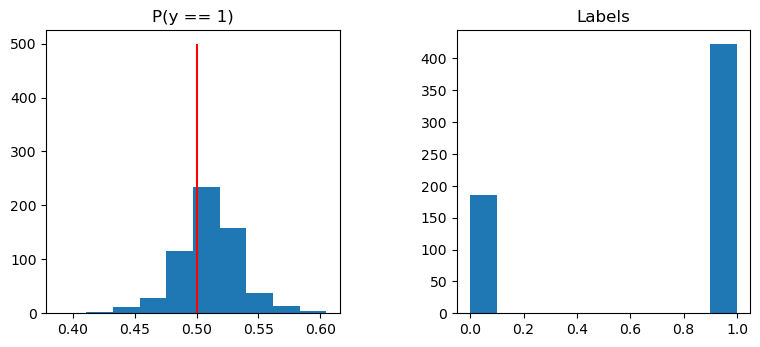

In [27]:
# predict on validation set
plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.2,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

y_pred = model.predict(validation_batch_generator)
y_pred = tf.math.sigmoid(y_pred).numpy() # TODO: for logits

# for probs
plt.subplot(1, 2, 1)
plt.hist(y_pred.reshape(-1))
plt.title('P(y == 1)')
plt.vlines(x=0.5, ymin=0, ymax=500, color='red')

y_pred = np.where(y_pred > 0.5, 1, 0) # as labels
plt.subplot(1, 2, 2)
plt.hist(y_pred.reshape(-1))
plt.title('Labels')

plt.show()

In [28]:
# load test data
print(f'Test set: {len(validation_indices)}') # TODO: separate test-set

test_batch_generator = DataGenerator(data_path=path, indices_dataset=validation_indices, batch_size=1) # TODO: separate test-set
y_test = np.empty(0)
for batch_index in range(len(test_batch_generator)):
    _, y_test_batch = test_batch_generator.__getitem__(batch_index)
    y_test = np.append(y_test, y_test_batch)

Test set: 619


accuracy: 0.6155088852988692
balanced accuracy: 0.5279730884826426
f1 (weighted): 0.6269472849206444
recall (weighted): 0.6155088852988692
precision (weighted): 0.6415292735790823


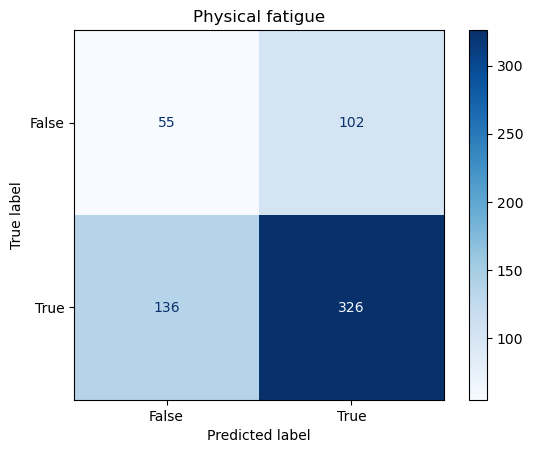

In [29]:
# classification metrics
# predict
y_test_pred = model.predict(test_batch_generator)
y_test_pred = tf.math.sigmoid(y_test_pred).numpy() # TODO: for logits
y_test_pred = np.round(y_test_pred)

# evaluate
accuracy = accuracy_score(y_pred=y_test_pred, y_true=y_test)
balanced_accuracy = balanced_accuracy_score(y_pred=y_test_pred, y_true=y_test)
f1_weighted = f1_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
recall_weighted = recall_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
precision_weighted = precision_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
confusion = confusion_matrix(y_pred=y_test_pred, y_true=y_test)
ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=[False, True]).plot(cmap=plt.cm.Blues)
plt.title('Physical fatigue')

print(f'accuracy: {accuracy}\n'
      f'balanced accuracy: {balanced_accuracy}\n'
      f'f1 (weighted): {f1_weighted}\n'
      f'recall (weighted): {recall_weighted}\n'
      f'precision (weighted): {precision_weighted}')

# Check same day segment prediction

In [30]:
X_dates = [meta['date'] for meta in metadata]

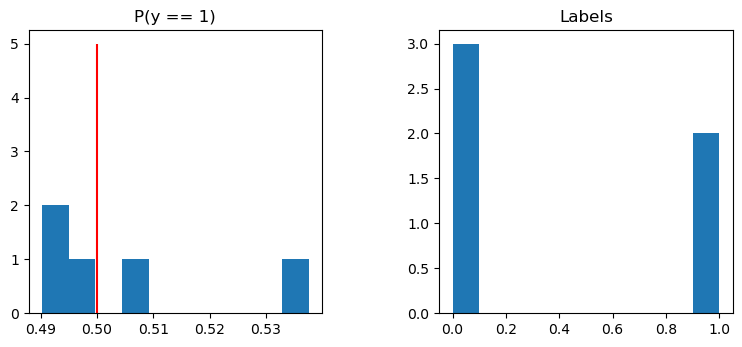

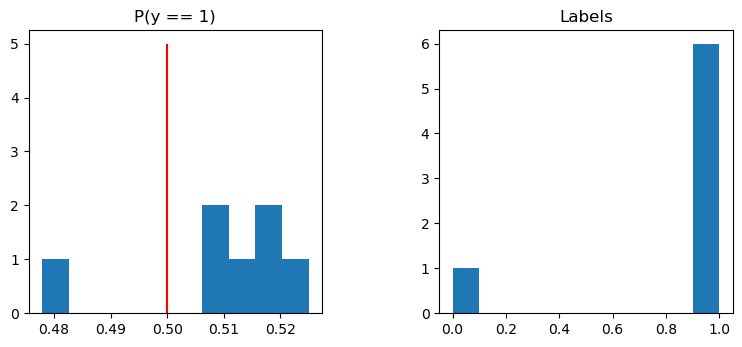

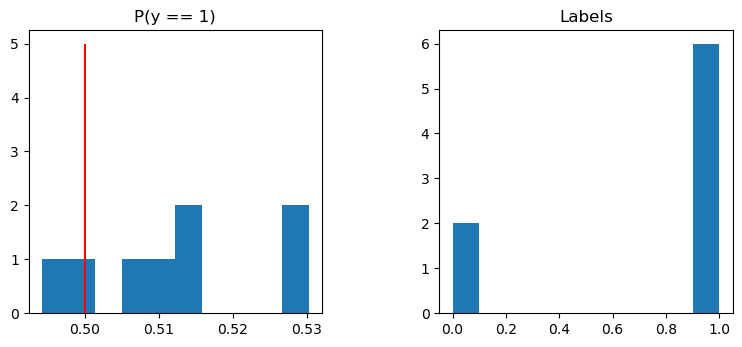

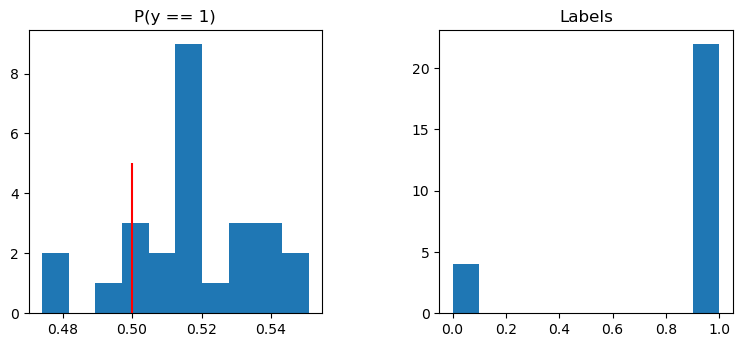

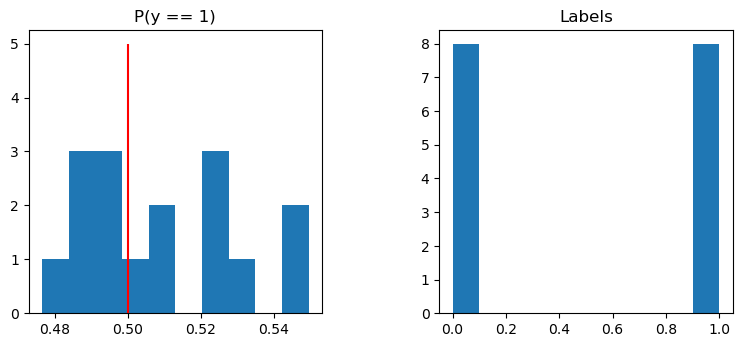

In [37]:
# analyze random day
for j in range(5):
    random_day = np.random.choice(np.unique(X_dates), 1)

    test_indices = [i for i in range(N) if X_dates[i] == random_day]
    test_batch_generator = DataGenerator(data_path=path, indices_dataset=test_indices, batch_size=1)

    # predict
    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=0.6,
                        wspace=0.4,
                        hspace=0.4)

    y_pred = model.predict(test_batch_generator)
    y_pred = tf.math.sigmoid(y_pred).numpy()

    # for probs
    plt.subplot(1, 2, 1)
    plt.hist(y_pred.reshape(-1))
    plt.title('P(y == 1)')
    plt.vlines(x=0.5, ymin=0, ymax=5, color='red')

    y_pred = np.where(y_pred > 0.5, 1, 0) # as labels
    plt.subplot(1, 2, 2)
    plt.hist(y_pred.reshape(-1))
    plt.title('Labels')

    plt.show()

# Check same day segment prediction (latest)

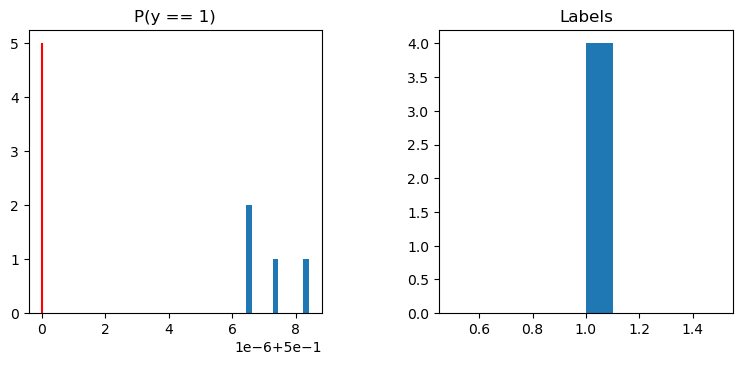

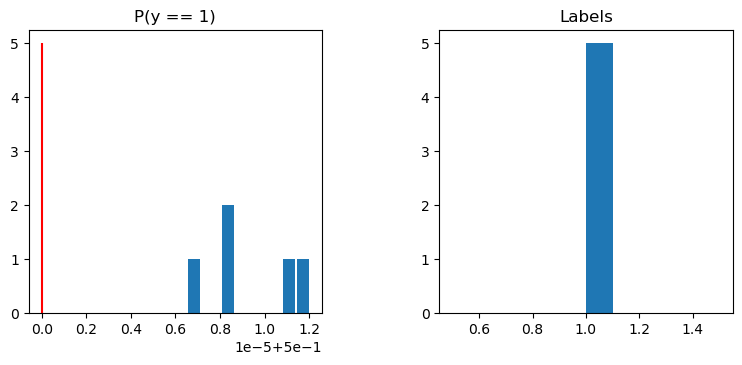

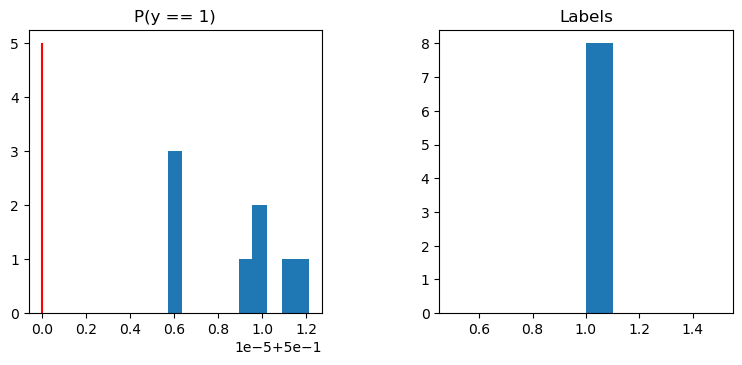

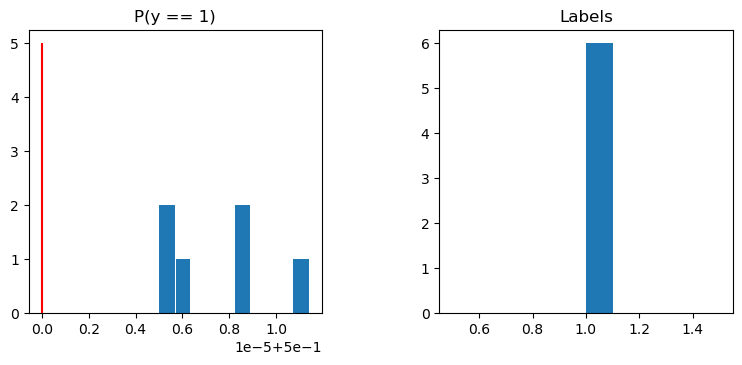

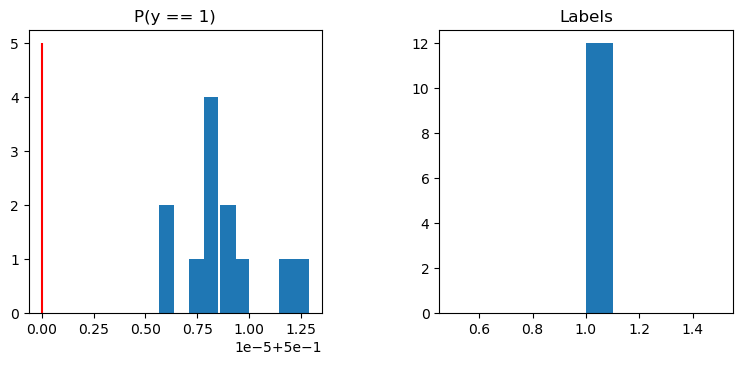

In [47]:
# analyze random day
for j in range(5):
    random_day = np.random.choice(np.unique(X_dates), 1)

    test_indices = [i for i in range(N) if X_dates[i] == random_day]
    test_batch_generator = DataGenerator(data_path=path, indices_dataset=test_indices, batch_size=1)

    # predict
    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=0.6,
                        wspace=0.4,
                        hspace=0.4)

    y_pred = current_model.predict(test_batch_generator)
    y_pred = tf.math.sigmoid(y_pred).numpy()

    # for probs
    plt.subplot(1, 2, 1)
    plt.hist(y_pred.reshape(-1))
    plt.title('P(y == 1)')
    plt.vlines(x=0.5, ymin=0, ymax=5, color='red')

    y_pred = np.where(y_pred > 0.5, 1, 0) # as labels
    plt.subplot(1, 2, 2)
    plt.hist(y_pred.reshape(-1))
    plt.title('Labels')

    plt.show()

# Save data

In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'recall_with_logits', 'precision_with_logits', 'f1', 'val_loss', 'val_accuracy', 'val_recall_with_logits', 'val_precision_with_logits', 'val_f1'])

In [39]:
# save history
with open('./temp/history_acc','w') as dat:
    dat.write(str(history.history['accuracy']))

with open('./temp/history_val_acc','w') as dat:
    dat.write(str(history.history['val_accuracy']))

with open('./temp/history_loss','w') as dat:
    dat.write(str(history.history['loss']))

with open('./temp/history_val_loss','w') as dat:
    dat.write(str(history.history['val_loss']))

with open('./temp/history_f1','w') as dat:
    dat.write(str(history.history['f1']))

with open('./temp/history_val_f1','w') as dat:
    dat.write(str(history.history['val_f1']))

In [42]:
# save latest model
current_model.save('./temp/checkpoint_latest')

INFO:tensorflow:Assets written to: ./temp/checkpoint_latest\assets


INFO:tensorflow:Assets written to: ./temp/checkpoint_latest\assets


INFO:tensorflow:Assets written to: ./temp/checkpoint_latest\assets


INFO:tensorflow:Assets written to: ./temp/checkpoint_latest\assets


# Continue training

In [100]:
# load latest
model = tf.keras.models.clone_model(model)
model.compile(optimizer=Adam(learning_rate=1e-5), loss=weighted_cross_entropy(sample_weight), metrics=[accuracy_with_logits(),
                                                                                                       recall_with_logits(),
                                                                                                       precision_with_logits(),
                                                                                                       BalancedAccuracy(),
                                                                                                       MCC(),
                                                                                                       F1()])

In [101]:
%%time
# save best performing model
checkpoint_path_mcc_2 = './temp/checkpoint_model_mcc_2'
model_checkpoint_callback_mcc_2 = ModelCheckpoint(filepath=checkpoint_path_mcc_2,
                                                save_weights_only=True,
                                                monitor='val_mcc',
                                                save_best_only=True)
checkpoint_path_f1_2 = './temp/checkpoint_model_f1_2'
model_checkpoint_callback_f1_2 = ModelCheckpoint(filepath=checkpoint_path_f1_2,
                                               save_weights_only=True,
                                               monitor='val_f1',
                                               save_best_only=True)

# train
history2 = model.fit_generator(generator=training_batch_generator,
                              validation_data=validation_batch_generator,
                              epochs=200,
                              callbacks=[model_checkpoint_callback_mcc_2, model_checkpoint_callback_f1_2])

Epoch 1/200
19/19 [==============================] - 39s 2s/step - loss: 1.1101 - accuracy: 0.3906 - recall_with_logits_5: 0.2734 - precision_with_logits_5: 0.7414 - balanced_accuracy: 0.5221 - mcc: 0.0392 - f1: 0.4418 - val_loss: 1.0967 - val_accuracy: 0.2664 - val_recall_with_logits_5: 0.0000e+00 - val_precision_with_logits_5: 0.0000e+00 - val_balanced_accuracy: 0.5000 - val_mcc: 0.0000e+00 - val_f1: 0.0592
Epoch 2/200
19/19 [==============================] - 29s 2s/step - loss: 1.1060 - accuracy: 0.3964 - recall_with_logits_5: 0.2875 - precision_with_logits_5: 0.7379 - balanced_accuracy: 0.5019 - mcc: 0.0036 - f1: 0.4144 - val_loss: 1.0920 - val_accuracy: 0.2615 - val_recall_with_logits_5: 0.0000e+00 - val_precision_with_logits_5: 0.0000e+00 - val_balanced_accuracy: 0.5000 - val_mcc: 0.0000e+00 - val_f1: 0.0422
Epoch 3/200
19/19 [==============================] - 31s 2s/step - loss: 1.1015 - accuracy: 0.4104 - recall_with_logits_5: 0.3158 - precision_with_logits_5: 0.7390 - balanced

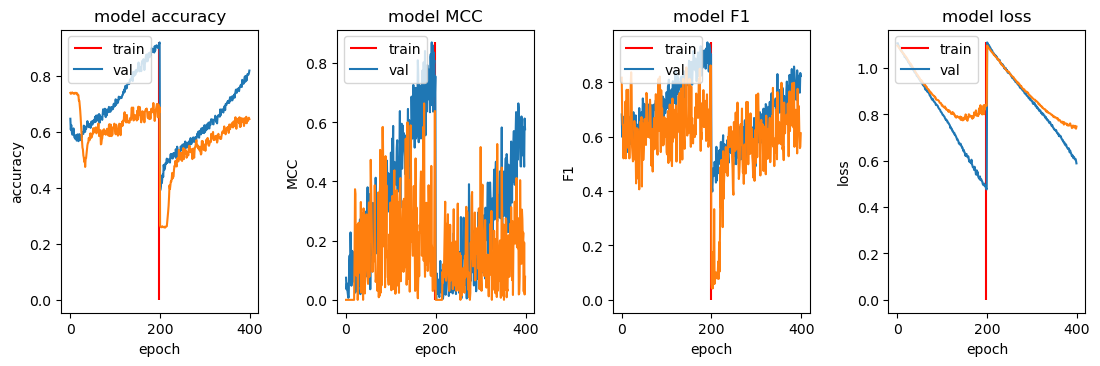

In [102]:
# plot training curve
plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.7,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

# metric
plt.subplot(1, 4, 1)
plt.vlines(x=np.argmax(history.history['val_f1']), ymin=0,
           ymax=max(history.history['accuracy'] + history.history['val_accuracy'] + history2.history['f1'] + history2.history['val_f1']), color='red')
plt.plot(history.history['accuracy'] + history2.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 4, 2)
plt.vlines(x=np.argmax(history.history['val_f1']), ymin=0,
           ymax=max(history.history['mcc'] + history.history['val_mcc'] + history2.history['f1'] + history2.history['val_f1']), color='red')
plt.plot(history.history['mcc'] + history2.history['mcc'])
plt.plot(history.history['val_mcc'] + history2.history['val_mcc'])
plt.title('model MCC')
plt.ylabel('MCC')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 4, 3)
plt.vlines(x=np.argmax(history.history['val_f1']), ymin=0,
           ymax=max(history.history['f1'] + history.history['val_f1'] + history2.history['f1'] + history2.history['val_f1']), color='red')
plt.plot(history.history['f1'] + history2.history['f1'])
plt.plot(history.history['val_f1'] + history2.history['val_f1'])
plt.title('model F1')
plt.ylabel('F1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# loss
plt.subplot(1, 4, 4)
plt.vlines(x=np.argmax(history.history['val_f1']), ymin=0,
           ymax=max(history.history['loss'] + history.history['val_loss'] + history2.history['loss'] + history2.history['val_loss']), color='red')
plt.plot(history.history['loss'] + history2.history['loss'])
plt.plot(history.history['val_loss'] + history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()